# Lab 3 - Clustering banco

En este cuaderno exploro el dataset del banco con la idea de agrupar clientes usando clustering. Es un enfoque sencillo, paso a paso, para practicar sin cosas avanzadas.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from matplotlib import cm


## 1. Cargar el dataset

Primero leo el archivo `bank-additional-full.csv` para tener los datos en un DataFrame.

In [40]:
data_path = '../../dataset/bank-additional-full.csv'
bank = pd.read_csv(data_path, sep=';')
print('Dimensiones del dataset:', bank.shape)
bank.head()


Dimensiones del dataset: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 2. Identificar columnas numericas

Para el clustering voy a usar solo columnas numericas porque es la forma mas sencilla de empezar. Reviso cuales son y obtengo un resumen rapido.

In [41]:
numeric_cols = bank.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Columnas numericas:', numeric_cols)

bank_numeric = bank[numeric_cols].copy()
bank_numeric.describe()


Columnas numericas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Tambien verifico si hay valores faltantes. Si no hay, puedo seguir sin limpiar nada extra.

In [42]:
missing_values = bank_numeric.isna().sum()
print('Valores faltantes por columna:')
print(missing_values[missing_values > 0])


Valores faltantes por columna:
Series([], dtype: int64)


## 3. Estandarizar los datos

Escalo las columnas numericas para que todas esten en la misma escala antes de aplicar K-Means.

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(bank_numeric)

print('Shape de los datos escalados:', scaled_data.shape)


Shape de los datos escalados: (41188, 10)


## 4. Elegir un número de clusters

Uso el método del codo con la librería Yellowbrick, que ya calcula la *distortion* (SSE normalizado) y dibuja la curva automáticamente. Así puedo ver visualmente dónde la curva deja de bajar tanto y escoger un `k` razonable.

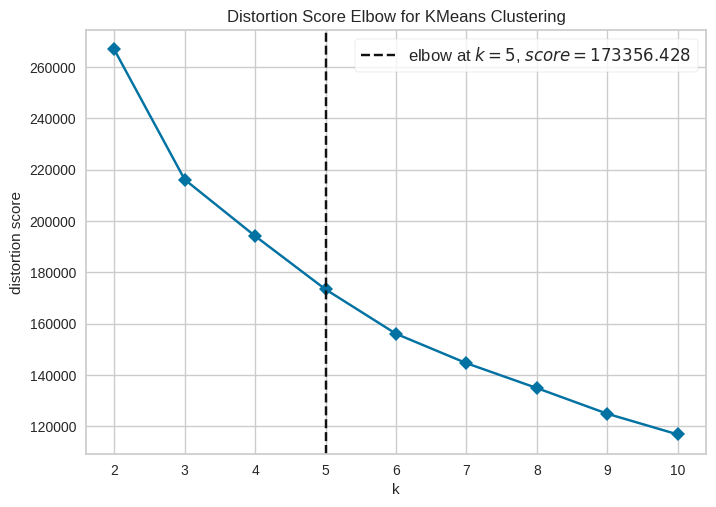

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
km = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 11), metric='distortion', timings=False)
visualizer.fit(scaled_data)
visualizer.show()


## 5. Entrenar K-Means

Elijo `k = 3` como punto de partida y entreno el modelo para obtener las etiquetas de cada cliente.

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

bank_numeric['cluster'] = clusters
print('Clientes por cluster:')
print(bank_numeric['cluster'].value_counts().sort_index())


Clientes por cluster:
cluster
0    12003
1    27645
2     1540
Name: count, dtype: int64


Tambien reviso los promedios de cada cluster para ver que los diferencia.

In [46]:
cluster_means = bank_numeric.groupby('cluster').mean()
cluster_means


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
cluster,,,,,,,,,,
0,39.393318,263.639840,2.124802,999.000000,0.317921,-2.025594,92.986577,-43.189461,1.202373,5077.975115
1,40.192838,252.392512,2.800940,999.000000,0.025249,1.117819,93.843861,-39.456763,4.818496,5213.419671
2,41.910390,322.326623,1.829870,22.134416,1.694805,-2.088442,93.352634,-38.334935,0.983318,5028.540909


## 6. Visualizar los clusters

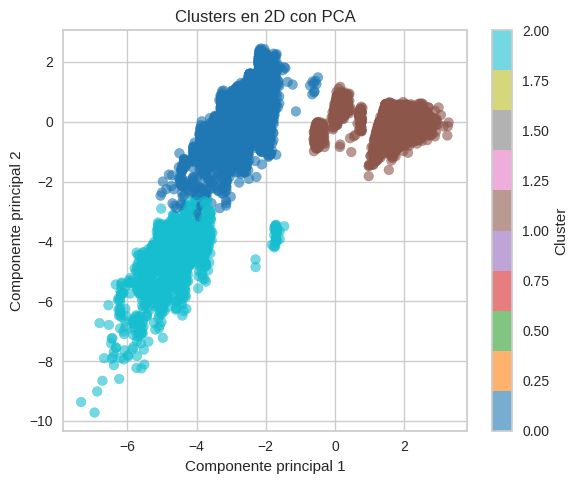

In [47]:
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters,
    cmap='tab10',
    alpha=0.6
)
plt.title('Clusters en 2D con PCA')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


## 7. Evaluar el clustering con silhouette score

Calculo el silhouette score para tener una idea de cuanto se separan los clusters entre si. Valores mas cercanos a 1 indican grupos bien definidos y valores cerca de 0 significan que se mezclan mucho.

In [48]:
silhouette = silhouette_score(scaled_data, clusters)
print(f'Silhouette score promedio: {silhouette:.3f}')


Silhouette score promedio: 0.439


Tambien hago un histograma y un grafico tipo "cuchillas" del silhouette score para ver la distribucion y como queda cada cluster.

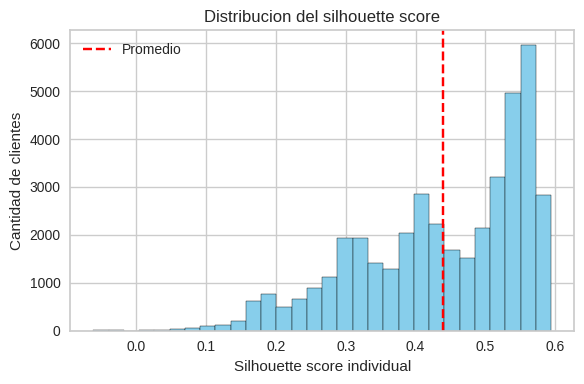

In [49]:
sample_silhouette = silhouette_samples(scaled_data, clusters)
plt.figure(figsize=(6, 4))
plt.hist(sample_silhouette, bins=30, color='skyblue', edgecolor='black')
plt.axvline(silhouette, color='red', linestyle='--', label='Promedio')
plt.title('Distribucion del silhouette score')
plt.xlabel('Silhouette score individual')
plt.ylabel('Cantidad de clientes')
plt.legend()
plt.tight_layout()
plt.show()


Tambien muestro el diagrama de siluetas (parece como cuchillas) para ver cada cluster y que tan ancho es su puntaje.

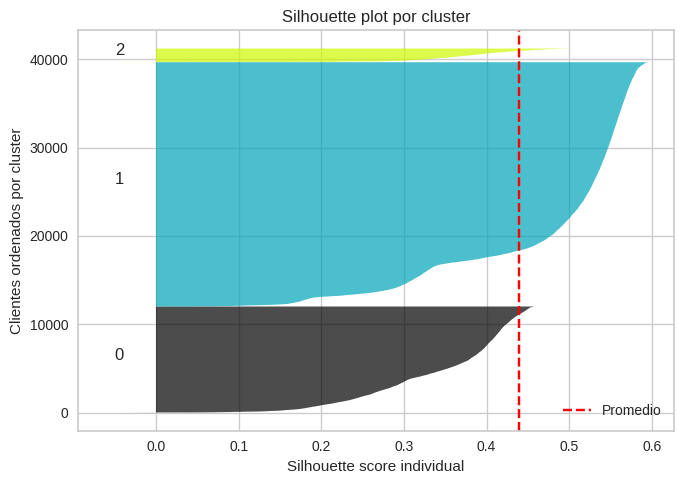

In [50]:
n_clusters = len(np.unique(clusters))
fig, ax = plt.subplots(figsize=(7, 5))
y_lower = 10
for cluster_id in range(n_clusters):
    cluster_sil = sample_silhouette[clusters == cluster_id]
    cluster_sil.sort()
    size_cluster = cluster_sil.shape[0]
    y_upper = y_lower + size_cluster
    color = cm.nipy_spectral(float(cluster_id) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil,
        facecolor=color,
        alpha=0.7
    )
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster_id))
    y_lower = y_upper + 10
ax.axvline(x=silhouette, color='red', linestyle='--', label='Promedio')
ax.set_title('Silhouette plot por cluster')
ax.set_xlabel('Silhouette score individual')
ax.set_ylabel('Clientes ordenados por cluster')
ax.legend()
plt.tight_layout()
plt.show()


## 8. Dendrograma simple

Para terminar, tomo una muestra de clientes y genero un dendrograma usando clustering jerarquico. Esto ayuda a ver como se van uniendo los grupos paso a paso.

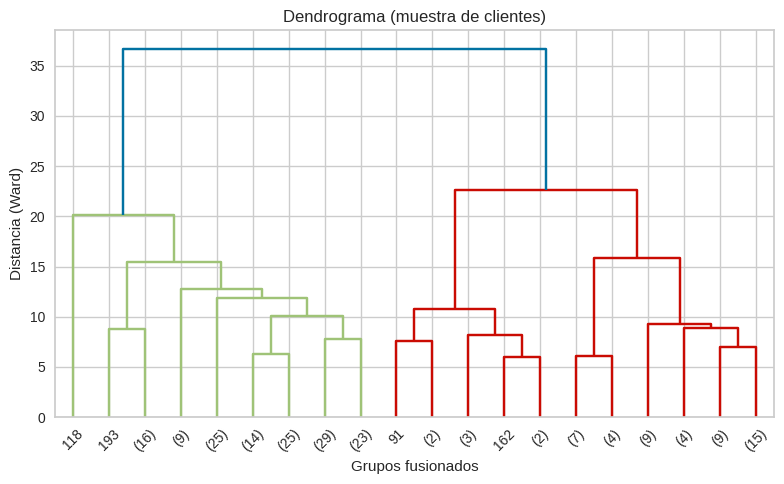

In [51]:
sample_size = 200
sample_data = bank[numeric_cols].sample(n=sample_size, random_state=42)
sample_scaled = scaler.transform(sample_data)

linked = linkage(sample_scaled, method='ward')

plt.figure(figsize=(8, 5))
dendrogram(
    linked,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=45,
    leaf_font_size=10
)
plt.title('Dendrograma (muestra de clientes)')
plt.xlabel('Grupos fusionados')
plt.ylabel('Distancia (Ward)')
plt.tight_layout()
plt.show()


## 9. Probar DBSCAN

In [52]:
dbscan = DBSCAN(eps=1.5, min_samples=15)
dbscan_labels = dbscan.fit_predict(scaled_data)

unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print('Clusters encontrados (incluye -1 como ruido):')
for label, count in zip(unique_labels, counts):
    print(f'Cluster {label}: {count}')


Clusters encontrados (incluye -1 como ruido):
Cluster -1: 433
Cluster 0: 26901
Cluster 1: 697
Cluster 2: 30
Cluster 3: 6479
Cluster 4: 2294
Cluster 5: 258
Cluster 6: 136
Cluster 7: 16
Cluster 8: 1953
Cluster 9: 504
Cluster 10: 632
Cluster 11: 310
Cluster 12: 72
Cluster 13: 19
Cluster 14: 84
Cluster 15: 89
Cluster 16: 30
Cluster 17: 123
Cluster 18: 32
Cluster 19: 40
Cluster 20: 23
Cluster 21: 18
Cluster 22: 15


/tmp/ipykernel_240594/1979050877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab10', len(unique_labels))


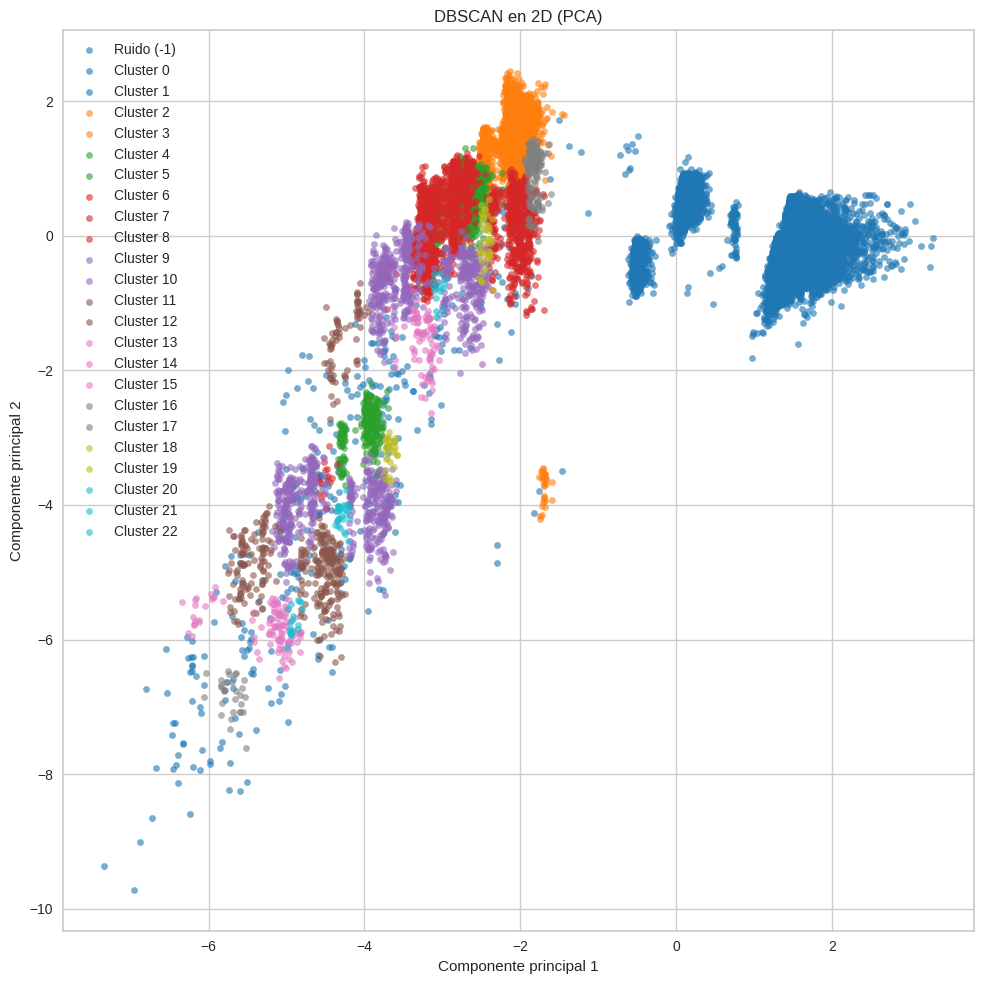

In [54]:
unique_labels = np.unique(dbscan_labels)
palette = cm.get_cmap('tab10', len(unique_labels))
label_colors = {label: palette(i) for i, label in enumerate(unique_labels)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = dbscan_labels == label
    color = label_colors[label]
    plt.scatter(
        pca_components[mask, 0],
        pca_components[mask, 1],
        s=20,
        alpha=0.6,
        color=color,
        label='Cluster ' + str(label) if label != -1 else 'Ruido (-1)'
    )
plt.title('DBSCAN en 2D (PCA)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
